In [133]:
# 1. Imports
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import re
import optuna

# modeling
from xgboost import XGBRegressor
from xgboost import XGBClassifier

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import log_loss
from scipy.special import logit, expit
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import confusion_matrix

# PyTorch for conversion model
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# nfl pbp loader
import nfl_data_py as nfl

# reproducibility
np.random.seed(42)
torch.manual_seed(42)

In [134]:
# 2a. Download PBP (this can take a few minutes)
seasons = [2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2024]
print("Loading play-by-play for seasons:", seasons)
raw_pbp = nfl.import_pbp_data(seasons, downcast=False)  # returns a DataFrame (may be large)

print("Rows loaded:", raw_pbp.shape[0])
raw_pbp.head()

Loading play-by-play for seasons: [2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2024]
2015 done.
2016 done.
2017 done.
2018 done.
2019 done.
2020 done.
2021 done.
2022 done.
2024 done.
Rows loaded: 433940


,play_id,game_id,old_game_id,home_team,away_team,season_type,week,posteam,posteam_type,defteam,...,was_pressure,route,defense_man_zone_type,defense_coverage_type,offense_names,defense_names,offense_positions,defense_positions,offense_numbers,defense_numbers
0,1.0,2015_01_BAL_DEN,2015091309,DEN,BAL,REG,1,None,None,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,36.0,2015_01_BAL_DEN,2015091309,DEN,BAL,REG,1,BAL,away,DEN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,51.0,2015_01_BAL_DEN,2015091309,DEN,BAL,REG,1,BAL,away,DEN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,75.0,2015_01_BAL_DEN,2015091309,DEN,BAL,REG,1,BAL,away,DEN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,96.0,2015_01_BAL_DEN,2015091309,DEN,BAL,REG,1,BAL,away,DEN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [135]:
def parse_weather(weather_str):
    """
    Parses a weather string into structured features:
        - temp_F: float
        - humidity: float (percentage)
        - wind_mph: float
        - wind_dir: str
        - conditions: str (general description, e.g., 'sunny', 'cloudy', etc.)
    """
    result = {
        "temp_F": None,
        "humidity": None,
        "wind_mph": None,
        "wind_dir": None,
        "conditions": None
    }
    
    if not isinstance(weather_str, str):
        return result
    
    lower_str = weather_str.lower()
    
    # Extract temperature
    temp_match = re.search(r'(\d+)\s*°?\s*f', lower_str)
    if temp_match:
        result['temp_F'] = float(temp_match.group(1))
    
    # Extract humidity
    hum_match = re.search(r'humidity[:\s]*(\d+)%', lower_str)
    if hum_match:
        result['humidity'] = float(hum_match.group(1))
    
    # Extract wind speed and direction
    wind_match = re.search(r'wind[:\s]*([nesw]+)\s*(\d+)\s*mph', lower_str)
    if wind_match:
        result['wind_dir'] = wind_match.group(1).upper()
        result['wind_mph'] = float(wind_match.group(2))
    
    # Extract general conditions
    conditions = []
    for cond in ['sunny', 'cloudy', 'clear', 'rain', 'snow', 'fog', 'drizzle', 'storm', 'windy']:
        if cond in lower_str:
            conditions.append(cond)
    if conditions:
        result['conditions'] = ','.join(conditions)
    
    return result


def deconstruct_weather(df, weather_col='weather'):
    """
    Adds structured weather columns to a DataFrame based on a weather string column.
    
    New columns added:
      - temp_F
      - humidity
      - wind_mph
      - wind_dir
      - conditions
    """
    weather_data = df[weather_col].apply(parse_weather)
    weather_df = pd.DataFrame(weather_data.tolist())
    df = pd.concat([df.reset_index(drop=True), weather_df], axis=1)
    
    # Fill missing wind speeds with 0
    df['wind_mph'] = df['wind_mph'].fillna(0)

    # Fill missing temperatures with 60°F
    df['temp_F'] = df['temp_F'].fillna(60)

    return df

In [136]:
cols_to_keep = ['play_type', 'play_type_actual', 'season', 'home_wp_post', 'away_wp_post', 'weather', 'yardline_100', 'ydstogo',
               'game_seconds_remaining', 'half_seconds_remaining', 'posteam', 'defteam',
               'posteam_timeouts_remaining', 'defteam_timeouts_remaining', 'kick_distance', 'touchback',
                'return_yards', 'first_down', 'touchdown', 'temp_F', 'wind_mph', 'game_id', 'score_differential',
                'home_team', 'away_team', 'home_score', 'away_score', 'down', 'field_goal_result', 'penalty']

In [137]:
pbp = raw_pbp.copy()

action_to_col = {
    "punt": "punt",
    "field_goal": "field_goal",
    "run": "go",
    "pass": "go"
}

pbp["play_type_actual"] = pbp["play_type"].map(action_to_col)
pbp = pbp[pbp.play_type_actual.isin(['punt', 'go', 'field_goal'])]
pbp = deconstruct_weather(pbp)
pbp = pbp[cols_to_keep].copy()
pbp = pbp[pbp.penalty == 0]
pbp['fg_made'] = (pbp["field_goal_result"] == "made").astype(int)

action_to_ewp_col = {
    "punt": "ewp_punt",
    "field_goal": "ewp_fg",
    "go": "ewp_go_adj"
}
pbp["actual_ewp_col"] = pbp["play_type_actual"].map(action_to_ewp_col)

In [138]:
seasons = pbp.season.unique() # seasons
test_season = seasons.max()

pbp_train = pbp[pbp.season != test_season]
pbp_test = pbp[pbp.season == test_season]

In [139]:
def make_temporal_folds(df, season_col="season", min_train_seasons=3):
    """
    Expanding-window CV folds by season.
    Returns list of (train_idx, val_idx).
    """
    seasons = np.sort(df[season_col].unique())
    folds = []

    for i in range(min_train_seasons, len(seasons)):
        train_seasons = seasons[:i]
        val_season = seasons[i]

        train_idx = df[df[season_col].isin(train_seasons)].index
        val_idx = df[df[season_col] == val_season].index

        folds.append((train_idx, val_idx))

    return folds

In [140]:
# --- Drop rows missing home/away WP
wp_df = pbp_train.dropna(subset=["home_wp_post", "away_wp_post"]).copy()

# --- Define features
wp_df["score_time_ratio"] = wp_df["score_differential"].abs() / (wp_df["game_seconds_remaining"] + 1)
wp_features = [
    "yardline_100",
    "down",
    "ydstogo",
    "game_seconds_remaining",
    "half_seconds_remaining",
    "score_differential",
    "posteam_timeouts_remaining",
    "defteam_timeouts_remaining",
    "score_time_ratio",
    "temp_F",
    "wind_mph"
]

# --- Define posteam WP target
wp_df["wp_target"] = np.where(
    wp_df["posteam"] == wp_df["home_team"],
    wp_df["home_wp_post"],
    wp_df["away_wp_post"]
)

wp_df = wp_df.reset_index(drop=True)

X_wp = wp_df[wp_features]
y_wp = wp_df["wp_target"]

# --- Clip target to avoid exact 0/1 ---
epsilon = 1e-6
y_wp_clipped = y_wp.clip(epsilon, 1 - epsilon).reset_index(drop=True)

# --- Monotone constraints
monotone_constraints_dict = {
    "yardline_100": -1,               # closer to opponent endzone → WP ↑
    "down": -1,                       # higher down (worse) → WP ↓
    "ydstogo": -1,                    # more yards to go → WP ↓
    "score_differential": 1,          # lead → WP ↑
    "posteam_timeouts_remaining": 1,  # more TOs → WP ↑
    "defteam_timeouts_remaining": -1  # opponent TOs → WP ↓
}

wp_folds = make_temporal_folds(wp_df)

In [141]:
def wp_objective(trial):

    params = {
        "max_depth": trial.suggest_int("max_depth", 3, 5),
        "learning_rate": trial.suggest_float("learning_rate", 0.02, 0.08),
        "n_estimators": trial.suggest_int("n_estimators", 200, 400),
        "subsample": trial.suggest_float("subsample", 0.7, 0.9),
        "min_child_weight": trial.suggest_int("min_child_weight", 20, 100),
        "verbosity": 0,
        "monotone_constraints": monotone_constraints_dict,
    }

    rmses = []

    for train_idx, val_idx in wp_folds:
        X_train, X_val = X_wp.iloc[train_idx], X_wp.iloc[val_idx]
        y_train, y_val = y_wp_clipped.iloc[train_idx], y_wp_clipped.iloc[val_idx]

        model = XGBRegressor(**params)
        model.fit(
            X_train,
            y_train,
            eval_set=[(X_val, y_val)],
            eval_metric="rmse",
            early_stopping_rounds=10,
            verbose=False
        )

        preds = model.predict(X_val)
        rmse = mean_squared_error(y_val, preds, squared=False)
        rmses.append(rmse)

    return np.mean(rmses)

In [142]:
wp_study = optuna.create_study(direction="minimize")
wp_study.optimize(wp_objective, n_trials=3)

[I 2026-01-06 01:09:52,353] A new study created in memory with name: no-name-13918fef-a6fb-4eac-9d82-613ace735af8
C:\Users\david\anaconda3\lib\site-packages\xgboost\sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\david\anaconda3\lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\david\anaconda3\lib\site-packages\xgboost\sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\david\anaconda3\lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for be

[I 2026-01-06 01:11:00,262] Trial 2 finished with value: 0.05985149218412972 and parameters: {'max_depth': 4, 'learning_rate': 0.056038967699141615, 'n_estimators': 335, 'subsample': 0.79307660553247, 'min_child_weight': 75}. Best is trial 2 with value: 0.05985149218412972.


In [143]:
best_params = wp_study.best_params
best_score = wp_study.best_value

print("Best CV RMSE:", best_score)
print("Best params:", best_params)

Best CV RMSE: 0.05985149218412972
Best params: {'max_depth': 4, 'learning_rate': 0.056038967699141615, 'n_estimators': 335, 'subsample': 0.79307660553247, 'min_child_weight': 75}


In [144]:
# Add monotone constraints if not in params already
best_params["monotone_constraints"] = monotone_constraints_dict
best_params["verbosity"] = 0

wp_model = XGBRegressor(**best_params)
wp_model.fit(X_wp, y_wp_clipped)  # Train on full dataset


def predict_wp(state_df):
    """
    Returns win probability for the team with possession in state_df.
    All EWPs are reported from the perspective of the pre-play offensive team.
    Therefore:
        - Use predict_wp(...) if possession is retained
        - Use 1 - predict_wp(...) if possession flips
    """
    
    if "score_time_ratio" not in state_df:
        state_df["score_time_ratio"] = state_df["score_differential"].abs() / (state_df["game_seconds_remaining"] + 1)
    preds = wp_model.predict(state_df[wp_features])
    return np.clip(preds, 0.0, 1.0)

In [145]:
def wp_symmetric_adjust(state_df, predict_wp):
    # Predict from original perspective
    wp = predict_wp(state_df)

    # Create flipped states
    state_flipped = state_df.copy()
    state_flipped["score_differential"] *= -1
    state_flipped[["posteam_timeouts_remaining", "defteam_timeouts_remaining"]] = \
        state_flipped[["defteam_timeouts_remaining", "posteam_timeouts_remaining"]].values
    state_flipped["yardline_100"] = 100 - state_flipped["yardline_100"]
    state_flipped["score_time_ratio"] = state_df["score_time_ratio"]
    
    wp_flipped = predict_wp(state_flipped)

    # Symmetric adjustment
    wp_sym = 0.5 * (wp + (1 - wp_flipped))
    
    # Weighting
    sym_weighting = 0.20
    
    return (1 - sym_weighting) * wp + sym_weighting * wp_sym

In [146]:
# Create punt_df with only punt plays
punt_df = pbp_train[pbp_train.play_type_actual == "punt"].dropna(subset=["kick_distance", "return_yards"]).copy()

# Compute net punt yardage: kick distance minus return yards, adjust for touchbacks (if available)
# Assuming touchback puts ball at 20-yard line
punt_df["net_punt"] = punt_df["kick_distance"] - punt_df["return_yards"]
punt_df.loc[punt_df["touchback"] == 1, "net_punt"] = punt_df["yardline_100"] - 20

# Reset index to avoid any issues
punt_df = punt_df.reset_index(drop=True)

# Make temporal folds based on seasons in punt_df
punt_folds = make_temporal_folds(punt_df, season_col="season", min_train_seasons=3)

# Features to predict net punt
punt_df["score_time_ratio"] = punt_df["score_differential"].abs() / (punt_df["game_seconds_remaining"] + 1)
punt_features = [
    "yardline_100", 
    "game_seconds_remaining", 
    "half_seconds_remaining",
    "score_differential",
    "score_time_ratio",
    "posteam_timeouts_remaining",
    "defteam_timeouts_remaining",
    "temp_F",
    "wind_mph"
]

X_punt = punt_df[punt_features].values
y_punt = punt_df["net_punt"].values

X_scaler = StandardScaler()
X_punt_scaled = X_scaler.fit_transform(X_punt)

y_scaler = StandardScaler()
y_punt_scaled = y_scaler.fit_transform(y_punt.reshape(-1,1))

In [147]:
def punt_objective(trial):
    
    # Suggest hyperparameters
    n_layers = trial.suggest_int("n_layers", 1, 3)
    hidden_size = trial.suggest_int("hidden_size", 16, 128)
    lr = trial.suggest_float("lr", 1e-4, 1e-2, log=True)
    dropout_rate = trial.suggest_float("dropout", 0.0, 0.5)
    epochs = 50

    rmses = []

    # Loop over temporal folds
    for train_idx, val_idx in punt_folds:
        # Prepare fold data
        X_train = torch.tensor(X_punt_scaled[train_idx], dtype=torch.float32)
        y_train = torch.tensor(y_punt_scaled[train_idx], dtype=torch.float32)
        X_val = torch.tensor(X_punt_scaled[val_idx], dtype=torch.float32)
        y_val = torch.tensor(y_punt_scaled[val_idx], dtype=torch.float32)

        input_dim = X_train.shape[1]

        # Build the network
        layers = []
        for i in range(n_layers):
            layers.append(nn.Linear(input_dim if i == 0 else hidden_size, hidden_size))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout_rate))
        layers.append(nn.Linear(hidden_size, 1))
        
        model = nn.Sequential(*layers)

        criterion = nn.MSELoss()
        optimizer = optim.Adam(model.parameters(), lr=lr)

        # Training loop
        model.train()
        for epoch in range(epochs):
            optimizer.zero_grad()
            outputs = model(X_train)
            loss = criterion(outputs, y_train)
            loss.backward()
            optimizer.step()

        # Validation
        model.eval()
        with torch.no_grad():
            val_preds = model(X_val)
            val_loss = criterion(val_preds, y_val).item()
            rmses.append(np.sqrt(val_loss))

    # Return mean RMSE across folds
    return np.mean(rmses)

In [148]:
punt_study = optuna.create_study(direction="minimize")
punt_study.optimize(punt_objective, n_trials=3)

[I 2026-01-06 01:11:05,959] A new study created in memory with name: no-name-86302022-1bae-4f81-b798-cc6037d2daad
[I 2026-01-06 01:11:08,164] Trial 0 finished with value: 0.9364462231967468 and parameters: {'n_layers': 3, 'hidden_size': 24, 'lr': 0.0012637378730115298, 'dropout': 0.13287760730930925}. Best is trial 0 with value: 0.9364462231967468.
[I 2026-01-06 01:11:09,052] Trial 1 finished with value: 0.9161925565549225 and parameters: {'n_layers': 1, 'hidden_size': 25, 'lr': 0.007128309097843487, 'dropout': 0.22118644108401514}. Best is trial 1 with value: 0.9161925565549225.
[I 2026-01-06 01:11:11,014] Trial 2 finished with value: 0.9186065416022868 and parameters: {'n_layers': 3, 'hidden_size': 23, 'lr': 0.002174600759015198, 'dropout': 0.0847154123331268}. Best is trial 1 with value: 0.9161925565549225.


In [149]:
best_params = punt_study.best_params
best_score = punt_study.best_value
n_layers = best_params["n_layers"]
hidden_size = best_params["hidden_size"]
dropout_rate = best_params["dropout"]
lr = best_params["lr"]

print("Best CV RMSE:", best_score)
print("Best params:", best_params)

Best CV RMSE: 0.9161925565549225
Best params: {'n_layers': 1, 'hidden_size': 25, 'lr': 0.007128309097843487, 'dropout': 0.22118644108401514}


In [150]:
# Build final model
layers = []
input_dim = X_punt_scaled.shape[1]
for i in range(n_layers):
    layers.append(nn.Linear(input_dim if i==0 else hidden_size, hidden_size))
    layers.append(nn.ReLU())
    layers.append(nn.Dropout(dropout_rate))
layers.append(nn.Linear(hidden_size, 1))
punt_model = nn.Sequential(*layers)

# Convert full data to tensors
X_t = torch.tensor(X_punt_scaled, dtype=torch.float32)
y_t = torch.tensor(y_punt_scaled, dtype=torch.float32)

optimizer = torch.optim.Adam(punt_model.parameters(), lr=lr)
loss_fn = nn.MSELoss()

# Train final model
epochs = 1000
for epoch in range(epochs):
    optimizer.zero_grad()
    preds = punt_model(X_t)
    loss = loss_fn(preds, y_t)
    loss.backward()
    optimizer.step()

In [151]:
# --- Filter to field goal attempts only ---
fg_df = pbp_train[pbp_train.play_type_actual == "field_goal"].dropna(subset=["field_goal_result"]).copy()
fg_df = fg_df[fg_df.field_goal_result.isin(['made', 'missed', 'blocked'])]

# Field goal
fg_df["score_time_ratio"] = fg_df["score_differential"].abs() / (fg_df["game_seconds_remaining"] + 1)
fg_features = [
    "yardline_100",
    "game_seconds_remaining",
    "half_seconds_remaining",
    "score_differential",
    "score_time_ratio",
    "temp_F",
    "wind_mph"
]

X_fg = fg_df[fg_features]
y_fg = fg_df["fg_made"]

fg_folds = make_temporal_folds(
    fg_df,
    season_col="season",
    min_train_seasons=3
)

fg_oof_pred = pd.Series(index=fg_df.index, dtype=float)
fg_df["fg_make_prob_oof"] = fg_oof_pred

for fold_num, (train_idx, val_idx) in enumerate(fg_folds, 1):
    X_train = X_fg.loc[train_idx]
    y_train = y_fg.loc[train_idx]
    X_val   = X_fg.loc[val_idx]

    fg_model_lr_fold = LogisticRegression(
        solver="lbfgs",
        max_iter=1000
    )

    fg_model_lr_fold.fit(X_train, y_train)

    fg_oof_pred.loc[val_idx] = fg_model_lr_fold.predict_proba(X_val)[:, 1]

mask = fg_oof_pred.notna()
fg_oof_rmse = np.sqrt(np.mean((fg_oof_pred[mask] - y_fg[mask]) ** 2))
print("FG (LogReg) OOF RMSE:", fg_oof_rmse)

fg_model = LogisticRegression(
    solver="lbfgs",
    max_iter=1000
)

fg_model.fit(X_fg, y_fg)

FG (LogReg) OOF RMSE: 0.3396162398418047


LogisticRegression(max_iter=1000)

In [152]:
max_fg = 65
fg_decay_threshold = 60

In [153]:
# Filter to 4th-down go-for-it plays
go_df = pbp_train[
    (pbp_train['down'] == 4) &
    (pbp_train['play_type_actual'] == 'go')  # filters out punts/FGs
].copy()

# Target: did the team convert?
go_df = go_df.dropna(subset=['first_down'])

# Go-for-it conversion
go_df["score_time_ratio"] = go_df["score_differential"].abs() / (go_df["game_seconds_remaining"] + 1)

go_df["success"] = (
    (go_df["first_down"] == 1) |
    (go_df["touchdown"] == 1)
).astype(int)

# Reset index to avoid any issues
go_df = go_df.reset_index(drop=True)

# Make temporal folds based on seasons in punt_df
go_folds = make_temporal_folds(go_df, season_col="season", min_train_seasons=3)

# Features to predict net punt
go_features = [
    "yardline_100",
    "ydstogo",
    "game_seconds_remaining",
    "half_seconds_remaining",
    "score_differential",
    "posteam_timeouts_remaining",
    "defteam_timeouts_remaining",
    "score_time_ratio",
    "temp_F",
    "wind_mph"
]

X_go = go_df[go_features].values
y_go = go_df["success"].values

In [154]:
monotone_constraints = [
    -1,  # yardline_100 (farther → worse)
    -1,  # ydstogo (longer → worse)
    0,   # game_seconds_remaining
    0,   # half_seconds_remaining
    1,   # score_differential
    0,   # posteam_timeouts_remaining
    0,   # defteam_timeouts_remaining
    -1,  # score_time_ratio
    0,   # temp_F
    0    # wind_mph
]

def go_objective(trial):
    # Suggest hyperparameters
    params = {
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
        "n_estimators": trial.suggest_int("n_estimators", 50, 500),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "objective": "binary:logistic",
        "monotone_constraints": tuple(monotone_constraints),
        "eval_metric": "logloss",
        "use_label_encoder": False
    }

    log_losses = []

    for train_idx, val_idx in go_folds:
        X_train, X_val = X_go[train_idx], X_go[val_idx]  # no scaler
        y_train, y_val = y_go[train_idx], y_go[val_idx]

        model = XGBClassifier(**params)
        model.fit(
            X_train, y_train,
            eval_set=[(X_val, y_val)],
            verbose=False
        )
        preds = model.predict_proba(X_val)[:, 1]
        log_losses.append(log_loss(y_val, preds))

    return np.mean(log_losses)

In [155]:
# Run Optuna search
go_study = optuna.create_study(direction="minimize")
go_study.optimize(go_objective, n_trials=3)

[I 2026-01-06 01:11:16,833] A new study created in memory with name: no-name-63afadd5-ed9d-4112-b726-cb1352e50306
[I 2026-01-06 01:11:36,156] Trial 0 finished with value: 0.6631215181100243 and parameters: {'max_depth': 5, 'learning_rate': 0.013540900984080862, 'n_estimators': 338, 'subsample': 0.6734568615433175, 'colsample_bytree': 0.7914780100649961}. Best is trial 0 with value: 0.6631215181100243.
[I 2026-01-06 01:11:46,449] Trial 1 finished with value: 0.6735324224621675 and parameters: {'max_depth': 3, 'learning_rate': 0.0014364671830650018, 'n_estimators': 296, 'subsample': 0.8937553615676862, 'colsample_bytree': 0.7739021597340643}. Best is trial 0 with value: 0.6631215181100243.
[I 2026-01-06 01:11:57,703] Trial 2 finished with value: 0.6701887232022844 and parameters: {'max_depth': 6, 'learning_rate': 0.0028156103878143788, 'n_estimators': 161, 'subsample': 0.6692120824307309, 'colsample_bytree': 0.855527439555191}. Best is trial 0 with value: 0.6631215181100243.


In [156]:
# Train final model with best hyperparameters
best_params = go_study.best_trial.params
best_params["monotone_constraints"] = tuple(monotone_constraints)
best_params["use_label_encoder"] = False
best_params["eval_metric"] = "logloss"

# Compute class imbalance weight
pos = (y_go == 1).sum()
neg = (y_go == 0).sum()
scale_pos_weight = neg / pos

go_model = XGBClassifier(**best_params, scale_pos_weight=scale_pos_weight)
go_model.fit(X_go, y_go)  # feed raw features, no scaling

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7914780100649961, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='logloss', feature_types=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.013540900984080862,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan,
              monotone_constraints=(-1, -1, 0, 0, 1, 0, 0, -1, 0, 0),
              multi_strategy=None, n_estimators=338, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [157]:
def sigmoid(x):
    
    return 1 / (1 + np.exp(-x))

In [158]:
def go_success_state_penalty(ydstogo, wp_current, game_seconds_remaining, strength=0.01, center=6, scale=3.5, time_scale=900):
    """
    Returns a bounded WP penalty applied to SUCCESSFUL go-for-it attempts,
    capturing execution fragility on long conversions.
    """
    y = np.asarray(ydstogo, dtype=float)
    wp = np.asarray(wp_current, dtype=float)
    t = np.asarray(game_seconds_remaining, dtype=float)

    # Distance-based ramp: flat → steep → flat
    dist_ramp = sigmoid((y - center) / scale)

    # WP weighting: strongest near 0.5, fades near 0 or 1
    wp_weight = 1 - 4 * (wp - 0.5) ** 2
    wp_weight = np.clip(wp_weight, 0, 1)

    # Time weighting: fades late in the game
    time_weight = np.clip(t / time_scale, 0, 1)

    return strength * dist_ramp * wp_weight * time_weight

In [159]:
def go_fail_state_penalty(ydstogo, max_extra=0.03, center=3.0, scale=1.5):
    """
    Returns an additive downside amount in [0, max_extra].
    Increases smoothly with ydstogo.

    max_extra=0.05 means: on very long tries, treat failure as up to
    5% WP worse than the raw failure-state WP.
    
    max_extra: max additional downside on failure (5 WP points)
    center: where the ramp turns on (yards)
    scale: smaller = steeper
    """
    y = np.asarray(ydstogo, dtype=float)
    ramp = sigmoid((y - center) / scale) # ~0 for y << center, ~1 for y >> center
    
    return max_extra * ramp

In [160]:
def go_for_it_field_position_risk(yardline_100, strength=0.03, center=55, scale=10):
    """
    Returns a non-negative WP penalty applied ONLY to go-for-it attempts,
    capturing asymmetric downside risk when backed up.
    """
    y = np.asarray(yardline_100, dtype=float)
    ramp = sigmoid((y - center) / scale) # ~0 when y << center, near 1 when y >> center

    return strength * ramp

In [161]:
def scoring_possessions_to_tie(score_differential):
    
    score_diff = np.asarray(score_differential)

    return np.where(score_diff < 0, np.ceil(np.abs(score_diff) / 8), 0)

In [162]:
def create_plays_df(df):
    
    # Compute final scores and win from offensive team perspective
    final_scores = (
        df.groupby("game_id")
           .tail(1)[["game_id","home_team","away_team","home_score","away_score"]]
           .copy()
    )
    final_scores["home_win"] = (final_scores["home_score"] > final_scores["away_score"]).astype(int)

    df = df.merge(final_scores[["game_id","home_win"]], on="game_id", how="left")
    df["win_actual"] = np.where(
        df["posteam"] == df["home_team"],
        df["home_win"],
        1 - df["home_win"]
    )
    
    return df

In [163]:
def create_next_fg_conv_states(df):
    
    # Next state if successful field goal attempt
    df['fg_success_yardline_100'] = 75
    df['fg_success_down'] = 1
    df['fg_success_ydstogo'] = 10
    df['fg_success_game_seconds_remaining'] = np.maximum(0, df['game_seconds_remaining'] - 5)
    df['fg_success_half_seconds_remaining'] = np.maximum(0, df['half_seconds_remaining'] - 5)
    df['fg_success_score_differential'] = -(df['score_differential'] + 3)
    df['fg_success_posteam_timeouts_remaining'] = df['defteam_timeouts_remaining']
    df['fg_success_defteam_timeouts_remaining'] = df['posteam_timeouts_remaining']
    df['fg_success_score_time_ratio'] = df['fg_success_score_differential'].abs() / (df['fg_success_game_seconds_remaining'] + 1)
    df['fg_success_temp_F'] = df['temp_F']
    df['fg_success_wind_mph'] = df['wind_mph']
    
    # Next state if failed field goal attempt
    df['fg_fail_yardline_100'] = 100 - (df['yardline_100'] + 7)
    df['fg_fail_down'] = 1
    df['fg_fail_ydstogo'] = 10
    df['fg_fail_game_seconds_remaining'] = np.maximum(0, df['game_seconds_remaining'] - 5)
    df['fg_fail_half_seconds_remaining'] = np.maximum(0, df['half_seconds_remaining'] - 5)
    df['fg_fail_score_differential'] = -df['score_differential']
    df['fg_fail_posteam_timeouts_remaining'] = df['defteam_timeouts_remaining']
    df['fg_fail_defteam_timeouts_remaining'] = df['posteam_timeouts_remaining']
    df['fg_fail_score_time_ratio'] = df['fg_fail_score_differential'].abs() / (df['fg_fail_game_seconds_remaining'] + 1)
    df['fg_fail_temp_F'] = df['temp_F']
    df['fg_fail_wind_mph'] = df['wind_mph']
    
    # Next state if successful conversion attempt
    df['go_success_yardline_100'] = df['yardline_100'] - df['ydstogo']
    df['go_success_down'] = 1
    df['go_success_ydstogo'] = np.minimum(10, df['go_success_yardline_100'])
    df['go_success_game_seconds_remaining'] = np.maximum(0, df['game_seconds_remaining'] - 5)
    df['go_success_half_seconds_remaining'] = np.maximum(0, df['half_seconds_remaining'] - 5)
    df['go_success_score_differential'] = df['score_differential']
    df['go_success_posteam_timeouts_remaining'] = df['posteam_timeouts_remaining']
    df['go_success_defteam_timeouts_remaining'] = df['defteam_timeouts_remaining']
    df['go_success_score_time_ratio'] = df['go_success_score_differential'].abs() / (df['go_success_game_seconds_remaining'] + 1)
    df['go_success_temp_F'] = df['temp_F']
    df['go_success_wind_mph'] = df['wind_mph']
    
    # Next state if failed conversion attempt
    df['go_fail_yardline_100'] = 100 - df['yardline_100']
    df['go_fail_down'] = 1
    df['go_fail_ydstogo'] = 10
    df['go_fail_game_seconds_remaining'] = np.maximum(0, df['game_seconds_remaining'] - 5)
    df['go_fail_half_seconds_remaining'] = np.maximum(0, df['half_seconds_remaining'] - 5)
    df['go_fail_score_differential'] = -df['score_differential']
    df['go_fail_posteam_timeouts_remaining'] = df['defteam_timeouts_remaining']
    df['go_fail_defteam_timeouts_remaining'] = df['posteam_timeouts_remaining']
    df['go_fail_score_time_ratio'] = df['go_fail_score_differential'].abs() / (df['go_fail_game_seconds_remaining'] + 1)
    df['go_fail_temp_F'] = df['temp_F']
    df['go_fail_wind_mph'] = df['wind_mph']
    
    return df

In [164]:
def calculate_ewp_fg(df):
    
    if "down" in df.columns:
        fourth_down_mask = df["down"] == 4
    else:
        fourth_down_mask = pd.Series(True, index=df.index)

    X_fg_success = df.loc[fourth_down_mask, [
        "fg_success_yardline_100",
        "fg_success_down",
        "fg_success_ydstogo",
        "fg_success_game_seconds_remaining",
        "fg_success_half_seconds_remaining",
        "fg_success_score_differential",
        "fg_success_posteam_timeouts_remaining",
        "fg_success_defteam_timeouts_remaining",
        "fg_success_score_time_ratio",
        "fg_success_temp_F",
        "fg_success_wind_mph"
    ]].copy()

    X_fg_success.columns = wp_features

    X_fg_fail = df.loc[fourth_down_mask, [
        "fg_fail_yardline_100",
        "fg_fail_down",
        "fg_fail_ydstogo",
        "fg_fail_game_seconds_remaining",
        "fg_fail_half_seconds_remaining",
        "fg_fail_score_differential",
        "fg_fail_posteam_timeouts_remaining",
        "fg_fail_defteam_timeouts_remaining",
        "fg_fail_score_time_ratio",
        "fg_fail_temp_F",
        "fg_fail_wind_mph"
    ]].copy()

    X_fg_fail.columns = wp_features
    
    wp_fg_success = 1 - wp_symmetric_adjust(X_fg_success, predict_wp)
    wp_fg_fail = 1 - wp_symmetric_adjust(X_fg_fail, predict_wp)

    # Predict FG make probability using current state
    X_fg_current = df.loc[fourth_down_mask, fg_features]
    p_make = fg_model.predict_proba(X_fg_current)[:, 1]
    yardlines = X_fg_current['yardline_100']
    p_make_decayed = np.where(yardlines >= (fg_decay_threshold - 17), p_make * np.maximum(0, (max_fg - 17 - yardlines) / (max_fg - fg_decay_threshold)), p_make)

    # Compute expected WP for FG attempt
    ewp_fg = np.full(len(df), np.nan)
    ewp_fg[fourth_down_mask] = np.clip(p_make_decayed * wp_fg_success + (1 - p_make_decayed) * wp_fg_fail, 0, 1)

    wp_fg_success_array = np.full(len(df), np.nan)
    wp_fg_success_array[fourth_down_mask] = wp_fg_success

    wp_fg_fail_array = np.full(len(df), np.nan)
    wp_fg_fail_array[fourth_down_mask] = wp_fg_fail

    # Save to DataFrame
    df["ewp_fg"] = ewp_fg
    df['wp_fg_success'] = wp_fg_success_array
    df['wp_fg_fail'] = wp_fg_fail_array
    df["p_make_fg"] = 0
    df.loc[fourth_down_mask, "p_make_fg"] = p_make_decayed
    
    return df

In [229]:
def calculate_ewp_go(df):
    
    if "down" in df.columns:
        fourth_down_mask = df["down"] == 4
    else:
        fourth_down_mask = pd.Series(True, index=df.index)
    
    X_go_success = df.loc[fourth_down_mask, [
        "go_success_yardline_100",
        "go_success_down",
        "go_success_ydstogo",
        "go_success_game_seconds_remaining",
        "go_success_half_seconds_remaining",
        "go_success_score_differential",
        "go_success_posteam_timeouts_remaining",
        "go_success_defteam_timeouts_remaining",
        "go_success_score_time_ratio",
        "go_success_temp_F",
        "go_success_wind_mph"
    ]].copy()

    X_go_success.columns = wp_features

    X_go_fail = df.loc[fourth_down_mask, [
        "go_fail_yardline_100",
        "go_fail_down",
        "go_fail_ydstogo",
        "go_fail_game_seconds_remaining",
        "go_fail_half_seconds_remaining",
        "go_fail_score_differential",
        "go_fail_posteam_timeouts_remaining",
        "go_fail_defteam_timeouts_remaining",
        "go_fail_score_time_ratio",
        "go_fail_temp_F",
        "go_fail_wind_mph"
    ]].copy()

    X_go_fail.columns = wp_features
    
    # WP if conversion succeeds (from current team's perspective)
    wp_go_success_raw = wp_symmetric_adjust(X_go_success, predict_wp)
    wp_go_success_raw_array = np.full(len(df), np.nan)
    wp_go_success_raw_array[fourth_down_mask] = wp_go_success_raw
    df["wp_go_success_raw"] = wp_go_success_raw_array
    
    masked_discrete_possessions_boost = df.loc[fourth_down_mask, "possessions_to_tie_boost"].to_numpy()
    wp_go_success_adj = np.clip(wp_go_success_raw + masked_discrete_possessions_boost, 0, 1)
    
    # Penalty to be applied only to success state
    go_success_penalty = go_success_state_penalty(
        ydstogo=df.loc[fourth_down_mask, "ydstogo"].to_numpy(),
        wp_current=df.loc[fourth_down_mask, "wp_current"].to_numpy(),
        game_seconds_remaining=df.loc[fourth_down_mask, "game_seconds_remaining"].to_numpy()
    )
    go_success_penalty_array = np.full(len(df), np.nan)
    go_success_penalty_array[fourth_down_mask] = go_success_penalty
    df["go_success_penalty"] = go_success_penalty_array
    
    # Adjust only the success state
    wp_go_success_adj = np.clip(wp_go_success_adj - go_success_penalty, 0, 1)
    wp_go_success_adj_array = np.full(len(df), np.nan)
    wp_go_success_adj_array[fourth_down_mask] = wp_go_success_adj
    df["wp_go_success_adj"] = wp_go_success_adj_array

    # WP if conversion fails (for us)
    wp_go_fail_raw = 1 - wp_symmetric_adjust(X_go_fail, predict_wp)
    wp_go_fail_raw_array = np.full(len(df), np.nan)
    wp_go_fail_raw_array[fourth_down_mask] = wp_go_fail_raw
    df["wp_go_fail_raw"] = wp_go_fail_raw_array
    
    # Penalty to be applied only to fail state
    go_fail_distance_penalty = go_fail_state_penalty(
        ydstogo=df.loc[fourth_down_mask, "ydstogo"].to_numpy()
    )
    go_fail_distance_penalty_array = np.full(len(df), np.nan)
    go_fail_distance_penalty_array[fourth_down_mask] = go_fail_distance_penalty
    df["go_fail_distance_penalty"] = go_fail_distance_penalty_array
    
    # Adjust only the fail state
    wp_go_fail_adj = np.clip(wp_go_fail_raw - go_fail_distance_penalty, 0, 1)
    wp_go_fail_adj_array = np.full(len(df), np.nan)
    wp_go_fail_adj_array[fourth_down_mask] = wp_go_fail_adj
    df["wp_go_fail_adj"] = wp_go_fail_adj_array

    # Predict conversion probability using current state
    X_go_current = df.loc[fourth_down_mask, go_features]
    p_convert = go_model.predict_proba(X_go_current)[:, 1]

    # Store conversion probability (prefer NaN outside 4th downs)
    p_convert_array = np.full(len(df), np.nan)
    p_convert_array[fourth_down_mask] = p_convert
    df["p_convert"] = p_convert_array
    
    # Compute raw expected WP for go-for-it attempt
    ewp_go_raw = np.full(len(df), np.nan)
    ewp_go_raw[fourth_down_mask] = p_convert * wp_go_success_raw + (1 - p_convert) * wp_go_fail_raw
    df.loc[fourth_down_mask, "ewp_go_raw"] = np.clip(ewp_go_raw[fourth_down_mask], 0, 1)

    # Compute expected WP for go-for-it attempt
    ewp_go = np.full(len(df), np.nan)
    ewp_go[fourth_down_mask] = p_convert * wp_go_success_adj + (1 - p_convert) * wp_go_fail_adj
    df["ewp_go"] = ewp_go

    # Field-position risk penalty (worse field position => more risk)
    go_field_position_penalty = go_for_it_field_position_risk(
        df.loc[fourth_down_mask, "yardline_100"].to_numpy(),
        strength=0.03,
        center=55,
        scale=10
    )

    go_field_position_penalty_array = np.full(len(df), np.nan)
    go_field_position_penalty_array[fourth_down_mask] = go_field_position_penalty
    df["go_field_position_penalty"] = go_field_position_penalty_array

    # Final adjusted go-for-it EWP
    df["ewp_go_adj"] = np.nan
    df.loc[fourth_down_mask, "ewp_go_adj"] = np.clip(
        df.loc[fourth_down_mask, "ewp_go"]
        - df.loc[fourth_down_mask, "go_field_position_penalty"],
        0,
        1
    )
    
    return df

In [230]:
def create_punt_next_state(df):
    
    if "down" in df.columns:
        fourth_down_mask = df["down"] == 4
    else:
        fourth_down_mask = pd.Series(True, index=df.index)
        
    X_punt_current = df.loc[fourth_down_mask, punt_features]

    # 1. Pandas → numpy
    X_punt_np = X_punt_current.values.astype(np.float32)

    # 2. Scale inputs
    X_punt_np_scaled = X_scaler.transform(X_punt_np)

    # 3. numpy → torch
    X_punt_tensor = torch.tensor(X_punt_np_scaled, dtype=torch.float32)

    # 4. Predict (scaled output)
    punt_model.eval()
    with torch.no_grad():
        y_scaled_pred = punt_model(X_punt_tensor).squeeze().cpu().numpy()

    # 5. Inverse transform target
    punt_pred_yards = y_scaler.inverse_transform(
        y_scaled_pred.reshape(-1, 1)
    ).ravel()

    punt_preds = np.zeros(len(df))
    punt_preds[fourth_down_mask] = punt_pred_yards
    
    df['punt_pred_yards'] = punt_preds
 
    landing_kicking = df['yardline_100'] - df['punt_pred_yards']
    landing_kicking = np.where(landing_kicking < 0, 20, landing_kicking)  # Only clip beyond goal line
    df['post_punt_yardline_100'] = 100 - landing_kicking # Flip possession

    df['post_punt_down'] = 1
    df['post_punt_ydstogo'] = 10
    df['post_punt_game_seconds_remaining'] = np.maximum(0, df['game_seconds_remaining'] - 8)
    df['post_punt_half_seconds_remaining'] = np.maximum(0, df['half_seconds_remaining'] - 8)
    df['post_punt_score_differential'] = -df['score_differential']
    df['post_punt_posteam_timeouts_remaining'] = df['defteam_timeouts_remaining']
    df['post_punt_defteam_timeouts_remaining'] = df['posteam_timeouts_remaining']
    df['post_punt_score_time_ratio'] = df['post_punt_score_differential'].abs() / (df['post_punt_game_seconds_remaining'] + 1)
    df['post_punt_temp_F'] = df['temp_F']
    df['post_punt_wind_mph'] = df['wind_mph']
    
    return df

In [231]:
def calculate_ewp_punt(df):
    
    if "down" in df.columns:
        fourth_down_mask = df["down"] == 4
    else:
        fourth_down_mask = pd.Series(True, index=df.index)

    X_post_punt = df.loc[fourth_down_mask, [
        "post_punt_yardline_100",
        "post_punt_down",
        "post_punt_ydstogo",
        "post_punt_game_seconds_remaining",
        "post_punt_half_seconds_remaining",
        "post_punt_score_differential",
        "post_punt_posteam_timeouts_remaining",
        "post_punt_defteam_timeouts_remaining",
        "post_punt_score_time_ratio",
        "post_punt_temp_F",
        "post_punt_wind_mph"
    ]].copy()

    X_post_punt.columns = wp_features
    
    wp_post_punt = 1 - wp_symmetric_adjust(X_post_punt, predict_wp)

    # Compute expected WP for FG attempt
    ewp_punt = np.full(len(df), np.nan)
    ewp_punt[fourth_down_mask] = wp_post_punt

    # Save to DataFrame
    df["ewp_punt"] = ewp_punt
    
    return df

In [232]:
def make_recommendations(df, test=False):
    
    ewp_cols = ["ewp_go_adj", "ewp_fg", "ewp_punt"]
    
    if not test:

        # Compute actual EWP for each row (using actual_ewp_col)
        bad = set(df["actual_ewp_col"].dropna().unique()) - set(df.columns)
        if bad:
            raise KeyError(f"actual_ewp_col points to missing columns: {bad}")

        col_idx = df[["actual_ewp_col"]].apply(
            lambda x: df.columns.get_loc(x[0]),
            axis=1
        ).to_numpy()

        row_idx = np.arange(len(df))
        df["ewp_actual"] = df.to_numpy()[row_idx, col_idx]

    # Compute best EWP
    df["ewp_best"] = df[ewp_cols].max(axis=1)

    # Mask
    valid = (df["down"] == 4) & df[ewp_cols].notna().all(axis=1)

    # decision margin only for valid rows (avoids weird NaNs)
    df["decision_margin"] = np.nan
    ewp_sorted = np.sort(df.loc[valid, ewp_cols].values, axis=1)
    df.loc[valid, "decision_margin"] = ewp_sorted[:, -1] - ewp_sorted[:, -2]
    
    col_to_action = {
        "ewp_punt": "punt",
        "ewp_fg": "field_goal",
        "ewp_go_adj": "go"
    }

    # determine best_col and recommended_play only for valid rows
    df["best_col"] = np.nan
    df.loc[valid, "best_col"] = df.loc[valid, ewp_cols].idxmax(axis=1)
    df["recommended_play"] = np.nan
    if valid.any():
        df.loc[valid, "recommended_play"] = (
            df.loc[valid, ewp_cols].idxmax(axis=1).map(col_to_action)
        )
    
    # For cases where we know play_type_actual
    if not test:
        df["regret_actual"] = df["ewp_best"] - df["ewp_actual"]
        
        # Identify disagreement (only meaningful when recommendation exists)
        df["disagreed"] = np.nan
        df.loc[valid, "disagreed"] = ~(
            ((df.play_type_actual == "punt") & (df.recommended_play == "punt")) |
            ((df.play_type_actual == "field_goal") & (df.recommended_play == "field_goal")) |
            ((df.play_type_actual == "go") & (df.recommended_play == "go"))
        )

        df["follow_model"] = np.nan
        df.loc[valid, "follow_model"] = (df.loc[valid, "actual_ewp_col"] == df.loc[valid, "best_col"]).astype(int)
       
    return df

In [233]:
def create_df_with_ewp(df, test=False):
    
    pbp_pre_computed = df.copy()
    pbp_pre_computed['wp_pred'] = wp_symmetric_adjust(pbp_pre_computed, predict_wp)
    
    if not test:
        pbp_pre_computed = create_plays_df(pbp_pre_computed)

    pbp_pre_computed.loc[:, "score_time_ratio"] = (
        pbp_pre_computed["score_differential"].abs() / (pbp_pre_computed["game_seconds_remaining"] + 1)
    )
    pbp_pre_computed['scoring_possessions_to_tie'] = scoring_possessions_to_tie(pbp_pre_computed['score_differential'])
    pbp_pre_computed['possessions_to_tie_boost'] = 0.02 / np.maximum(1, pbp_pre_computed['scoring_possessions_to_tie'])
    pbp_pre_computed['wp_current'] = wp_symmetric_adjust(pbp_pre_computed[wp_features], predict_wp)
    
    pbp_pre_computed = create_next_fg_conv_states(pbp_pre_computed)

    pbp_pre_computed = calculate_ewp_fg(pbp_pre_computed)
    pbp_pre_computed = calculate_ewp_go(pbp_pre_computed)
    pbp_pre_computed = create_punt_next_state(pbp_pre_computed)
    pbp_pre_computed = calculate_ewp_punt(pbp_pre_computed)
    
    pbp_pre_computed = make_recommendations(pbp_pre_computed, test=test)
    pbp_fourth = pbp_pre_computed.loc[pbp_pre_computed["down"] == 4].copy()
    
    return pbp_pre_computed, pbp_fourth

In [234]:
pbp_pre_computed, pbp_fourth = create_df_with_ewp(pbp_test)

In [235]:
state = {
    "yardline_100": 20,             
    "down": 4,
    "ydstogo": 14,                   
    "game_seconds_remaining": 900,   
    "half_seconds_remaining": 900,
    "score_differential": 0,       
    "posteam_timeouts_remaining": 3,
    "defteam_timeouts_remaining": 3,
    "temp_F" : 88,
    "wind_mph" : 13
}

test_state = pd.DataFrame([state])
test_pbp_pre_computed, test_pbp_fourth = create_df_with_ewp(test_state, test=True)

In [236]:
test_report_cols = ['wp_current', 'ewp_punt', 'ewp_fg', 'ewp_go_adj', 'ewp_go_raw', 'recommended_play', ]
test_pbp_pre_computed[test_report_cols]

,wp_current,ewp_punt,ewp_fg,ewp_go_adj,ewp_go_raw,recommended_play
0,0.573979,0.539255,0.607399,0.543577,0.563311,field_goal


Brier score: 0.15964
Reliability: 0.00058
Resolution: 0.09032
Uncertainty: 0.25000
Brier check (reliability - resolution + uncertainty): 0.16026


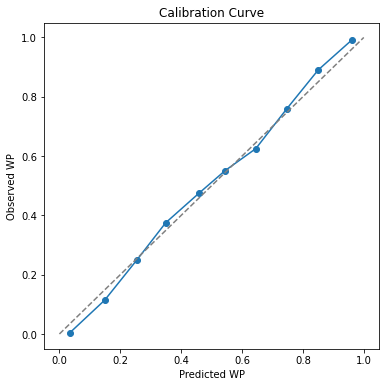

In [237]:
# Compute calibration, Brier score, reliability/resolution
# Bin predicted WP
bins = np.linspace(0, 1, 11)
wp_bin = pd.cut(pbp_pre_computed['wp_pred'], bins, include_lowest=True)

# Aggregate by bin
cal_table = pbp_pre_computed.groupby(wp_bin).agg(
    wp_pred_mean=('wp_pred', 'mean'),
    win_rate=('win_actual', 'mean'),
    count=('win_actual', 'count')
).reset_index()

# Brier score
brier = np.mean((pbp_pre_computed['wp_pred'] - pbp_pre_computed['win_actual'])**2)

# Reliability and resolution
N = len(pbp_pre_computed)
reliability = np.sum(cal_table['count'] / N * (cal_table['wp_pred_mean'] - cal_table['win_rate'])**2)
resolution = np.sum(cal_table['count'] / N * (cal_table['win_rate'] - pbp_pre_computed['win_actual'].mean())**2)
uncertainty = np.mean(pbp_pre_computed['win_actual']) * (1 - np.mean(pbp_pre_computed['win_actual']))
brier_check = reliability - resolution + uncertainty

# Print results
print(f"Brier score: {brier:.5f}")
print(f"Reliability: {reliability:.5f}")
print(f"Resolution: {resolution:.5f}")
print(f"Uncertainty: {uncertainty:.5f}")
print(f"Brier check (reliability - resolution + uncertainty): {brier_check:.5f}")

# Plot calibration
x = cal_table['wp_pred_mean'].values.ravel()  # ensures 1D
y = cal_table['win_rate'].values.ravel()     # ensures 1D

plt.figure(figsize=(6,6))
plt.plot(x, y, marker='o')
plt.plot([0,1], [0,1], '--', color='gray')
plt.xlabel('Predicted WP')
plt.ylabel('Observed WP')
plt.title('Calibration Curve')
plt.show()

In [238]:
cal_table

,wp_pred,wp_pred_mean,win_rate,count
0,"(-0.001, 0.1]",0.034568,0.004376,4342
1,"(0.1, 0.2]",0.148747,0.114060,2788
2,"(0.2, 0.3]",0.253810,0.248746,2790
3,"(0.3, 0.4]",0.349036,0.374940,4166
4,"(0.4, 0.5]",0.458625,0.474819,4964
5,"(0.5, 0.6]",0.544224,0.550811,4379
6,"(0.6, 0.7]",0.645140,0.625000,4232
7,"(0.7, 0.8]",0.747083,0.759551,3298
8,"(0.8, 0.9]",0.850189,0.890370,2700
9,"(0.9, 1.0]",0.961974,0.992668,3955


In [239]:
bins = np.linspace(0, 1, 11)
calibration_df = pd.DataFrame(index=pd.IntervalIndex.from_tuples([(round(bins[i],2), round(bins[i+1],2)) for i in range(len(bins)-1)]))

# Function to compute empirical win fraction per bin
def empirical_win_fraction(pred_col):
    return pbp_fourth.groupby(pd.cut(pbp_fourth[pred_col], bins=bins))['win_actual'].mean()

# Compute results for each play type
calibration_df['ewp_punt'] = round(empirical_win_fraction('ewp_punt'),3)
calibration_df['ewp_fg'] = round(empirical_win_fraction('ewp_fg'),3)
calibration_df['ewp_go_adj'] = round(empirical_win_fraction('ewp_go_adj'),3)

# Bins indicate predicted wp bin; columns are how often a team actually won in that predicted wp bin
calibration_df

,ewp_punt,ewp_fg,ewp_go_adj
"(0.0, 0.1]",0.016,0.014,0.023
"(0.1, 0.2]",0.091,0.140,0.119
"(0.2, 0.3]",0.258,0.302,0.276
"(0.3, 0.4]",0.399,0.398,0.405
"(0.4, 0.5]",0.454,0.508,0.477
"(0.5, 0.6]",0.496,0.543,0.517
"(0.6, 0.7]",0.637,0.685,0.692
"(0.7, 0.8]",0.743,0.753,0.758
"(0.8, 0.9]",0.895,0.909,0.915
"(0.9, 1.0]",1.000,0.997,1.000


In [240]:
ewp_columns = ['ewp_punt', 'ewp_fg', 'ewp_go_adj']

# Boolean mask of violations
violation_mask = (pbp_fourth[ewp_columns] < 0) | (pbp_fourth[ewp_columns] > 1)

# Count violations per column
violations = violation_mask.sum()

if violations.sum() == 0:
    print("No EWP violations detected.")
else:
    print("Violations detected:")
    print(violations)
    print(pbp_fourth[violation_mask.any(axis=1)].head())

No EWP violations detected.


In [241]:
state = pbp_fourth[wp_features]
state_flipped = state.copy()
state_flipped["score_differential"] *= -1
state_flipped[["posteam_timeouts_remaining","defteam_timeouts_remaining"]] = (
    state_flipped[["defteam_timeouts_remaining","posteam_timeouts_remaining"]].values
)
state_flipped["yardline_100"] = 100 - state_flipped["yardline_100"]
state_flipped["score_time_ratio"] = state_flipped["score_differential"].abs() / (state_flipped["game_seconds_remaining"] + 1)

wp = wp_symmetric_adjust(state, predict_wp)
wp_flipped = wp_symmetric_adjust(state_flipped, predict_wp)
flip_err = wp + wp_flipped - 1

flip_err.mean()

0.010567301

In [249]:
# Conditional mean regret
pbp_fourth[pbp_fourth.follow_model == 0].regret_actual.mean()

0.017196002709441015

In [243]:
# Compute regret stats by play type ---
regret_by_play = pbp_fourth.groupby('play_type_actual')['regret_actual'].agg(['mean', 'median'])
pbp_fourth['regret_actual'] = pd.to_numeric(pbp_fourth['regret_actual'], errors='coerce')

# Compute stats
regret_by_play = pbp_fourth.groupby('play_type_actual')['regret_actual'].agg(['size', 'mean', 'median'])
regret_by_play['95th'] = pbp_fourth.groupby('play_type_actual')['regret_actual'].quantile(0.95)

print("Regret by Play Type:")
regret_by_play

Regret by Play Type:


,size,mean,median,95th
play_type_actual,,,,
field_goal,1060,0.001792,0.000000,0.012412
go,806,0.013225,0.005834,0.050437
punt,1939,0.000636,0.000000,0.000470


In [244]:
# Regret vs margin for disagreements
df_disagree = pbp_pre_computed[pbp_pre_computed["disagreed"] == True].copy()
disagree_bins = pd.qcut(df_disagree["decision_margin"], q=10, duplicates="drop")
regret_by_margin = df_disagree.groupby(disagree_bins)["regret_actual"].agg(
    mean="mean",
    p95=lambda x: np.percentile(x, 95),
    count="count"
)
print("Regret vs Decision Margin (Disagreements)")
display(regret_by_margin)

# Bin decision margin
pbp_fourth["margin_bin"] = pd.qcut(pbp_fourth["decision_margin"], 10)
follow_by_margin = pbp_fourth.groupby("margin_bin").agg(
    follow_rate=("follow_model", "mean"),
    count=("follow_model", "size")
)
print("Follow Model Rate vs Decision Margin")
follow_by_margin

Regret vs Decision Margin (Disagreements)


,mean,p95,count
decision_margin,,,
"(-0.001, 0.00109]",0.002567,0.011703,81
"(0.00109, 0.00261]",0.003294,0.008356,80
"(0.00261, 0.00487]",0.00544,0.015528,80
"(0.00487, 0.00724]",0.007754,0.015905,80
"(0.00724, 0.0102]",0.010517,0.021349,80
"(0.0102, 0.0134]",0.014601,0.020378,80
"(0.0134, 0.0168]",0.017798,0.024414,80
"(0.0168, 0.0219]",0.019889,0.025093,80
"(0.0219, 0.0318]",0.028761,0.034003,80


Follow Model Rate vs Decision Margin


,follow_rate,count
margin_bin,,
"(-0.001, 0.00368]",0.464567,381
"(0.00368, 0.00915]",0.584211,380
"(0.00915, 0.0145]",0.637795,381
"(0.0145, 0.0199]",0.697368,380
"(0.0199, 0.0259]",0.829396,381
"(0.0259, 0.0343]",0.860526,380
"(0.0343, 0.0447]",0.947368,380
"(0.0447, 0.0597]",0.950131,381
"(0.0597, 0.0812]",0.952632,380


In [245]:
pbp_fourth[(pbp_fourth.decision_margin > .05)].groupby('recommended_play')['regret_actual'].agg(['mean', 'size'])

,mean,size
recommended_play,,
field_goal,0.004144,174
go,0.013572,19
punt,0.002759,805


In [246]:
test = pbp_fourth[pbp_fourth.season == 2024]

labels = ["punt", "field_goal", "go"]

cm_df = test[["play_type_actual", "recommended_play"]].dropna()

cm = confusion_matrix(
    cm_df["play_type_actual"].astype(str),
    cm_df["recommended_play"].astype(str),
    labels=labels
)

confusion = pd.DataFrame(
    cm,
    index=pd.Index(labels, name="Actual"),
    columns=pd.Index(labels, name="Recommended")
)

confusion

Recommended,punt,field_goal,go
Actual,,,
punt,1829,58,52
field_goal,72,870,118
go,333,169,304


In [247]:
confusion_norm = confusion.div(confusion.sum(axis=1), axis=0)
round(confusion_norm,4)

Recommended,punt,field_goal,go
Actual,,,
punt,0.9433,0.0299,0.0268
field_goal,0.0679,0.8208,0.1113
go,0.4132,0.2097,0.3772


In [248]:
cols = [
    "regret_actual",
    "follow_model",
    "go_success_penalty",
    "go_fail_distance_penalty",
    "go_field_position_penalty"
]

corr = pbp_fourth[cols].corr()
corr

,regret_actual,follow_model,go_success_penalty,go_fail_distance_penalty,go_field_position_penalty
regret_actual,1.000000,-0.591722,-0.189351,-0.090337,-0.063709
follow_model,-0.591722,1.000000,0.324965,0.238234,0.234449
go_success_penalty,-0.189351,0.324965,1.000000,0.495165,0.111590
go_fail_distance_penalty,-0.090337,0.238234,0.495165,1.000000,0.167445
go_field_position_penalty,-0.063709,0.234449,0.111590,0.167445,1.000000
